## Logistic Regression for Pets (Predicting Species)

Downloading Dataset Using Python Script

In [ ]:
import requests
import tarfile
import os

# URLs for images and annotations
datasets = {
    "images": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
    "annotations": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
}

base_dir = "oxford_pets"
os.makedirs(base_dir, exist_ok=True)

# Download and extract both datasets
for name, url in datasets.items():
    print(f"Processing {name} dataset...")
    
    # Download the dataset
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        tar_path = os.path.join(base_dir, f"{name}.tar.gz")
        with open(tar_path, "wb") as f:
            f.write(response.content)
        print(f"{name} dataset downloaded.")
        
        # Extract the dataset
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(base_dir)
        print(f"{name} dataset extracted.")
        
        # Remove the tar file to save space
        os.remove(tar_path)
    else:
        print(f"Failed to download {name} dataset.")

# Verify extraction
images_path = os.path.join(base_dir, "images")
annotations_path = os.path.join(base_dir, "annotations")

print("\nDatasets are ready:")
print(f"Images directory: {images_path}")
print(f"Annotations directory: {annotations_path}")


Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import learning_curve

In [3]:
base_dir = "oxford_pets"
images_path = os.path.join(base_dir, "images")
annotations_path = os.path.join(base_dir, "annotations")
annotations_file = os.path.join(annotations_path, "trainval.txt")


Reading annotations file and assigning custom column names

In [4]:
annotations = pd.read_csv(annotations_file, header=None, sep=" ", names=["image", "class", "species", "breed_id"])

In [5]:
annotations['label'] = annotations['species'].map({1: 0, 2: 1}) # 0 for cat, 1 for dog
annotations = annotations[annotations['class'].between(4, 8)] # Specifying 5 CLASSES to work with

In [6]:
print(annotations)


                 image  class  species  breed_id  label
150   basset_hound_100      4        2         3      1
151   basset_hound_101      4        2         3      1
152   basset_hound_102      4        2         3      1
153   basset_hound_103      4        2         3      1
154   basset_hound_104      4        2         3      1
...                ...    ...      ...       ...    ...
2238        Bombay_193      8        1         4      0
2239        Bombay_194      8        1         4      0
2240        Bombay_198      8        1         4      0
2241         Bombay_19      8        1         4      0
2242          Bombay_1      8        1         4      0

[496 rows x 5 columns]


Loading images and preparing for model

In [7]:
def load_and_preprocess_images(images_path, annotations, img_size=(64, 64)):
    X, y = [], []

    for _, row in annotations.iterrows():
        img_name = row['image']

        # Load and preprocess the image
        img_path = os.path.join(images_path, img_name + ".jpg")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize image
            img = img / 255.0  # normalize pixel values to [0, 1]
            img = img.flatten()  # flatten image to 1D
            X.append(img)

            y.append([row['label']])

    
    return np.array(X), np.array(y)

In [8]:
X, y = load_and_preprocess_images(images_path, annotations)

In [9]:
X.shape

(496, 12288)

In [10]:
y.shape

(496, 1)

Split and train X & y

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
species = LogisticRegression(max_iter=1000)
species.fit(X_train, y_train)

C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000)

In [13]:
y_pred = species.predict(X_test)

Report of the trained model

In [14]:
print("Accuracy for Class:", accuracy_score(y_test, y_pred))

Classification Report for Species:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        84
           1       0.67      0.57      0.62        65

    accuracy                           0.69       149
   macro avg       0.69      0.68      0.68       149
weighted avg       0.69      0.69      0.69       149

Accuracy for Class: 0.6912751677852349


Ploting and testing the model for visualization

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm= confusion_matrix(y_test, y_pred)
cm

array([[66, 18],
       [28, 37]])

Text(33.22222222222222, 0.5, 'Truth')

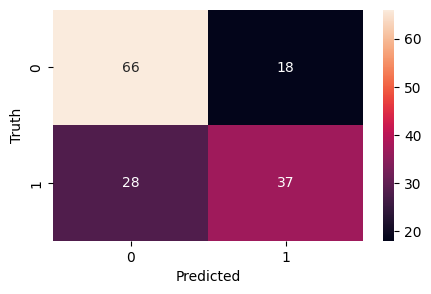

In [16]:
import seaborn as sn
plt.figure(figsize=(5,3))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [17]:
y_prob_lr = species.predict_proba(X_test)[:, 1]  # Probabilities for ROC

In [18]:
# Loss Curve
train_sizes, train_scores, test_scores = learning_curve(species, X_train, y_train, cv=5, scoring='neg_log_loss')
train_loss = -np.mean(train_scores, axis=1)
test_loss = -np.mean(test_scores, axis=1)

C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was pass

In [19]:
for size, train_l, test_l in zip(train_sizes, train_loss, test_loss):
    print(f"Training Size: {size}, Training Loss: {train_l:.4f}, Test Loss: {test_l:.4f}")

Training Size: 27, Training Loss: 0.0093, Test Loss: 1.2308
Training Size: 90, Training Loss: 0.0132, Test Loss: 1.3408
Training Size: 152, Training Loss: 0.0153, Test Loss: 1.1808
Training Size: 214, Training Loss: 0.0169, Test Loss: 1.2629
Training Size: 277, Training Loss: 0.0186, Test Loss: 1.2599


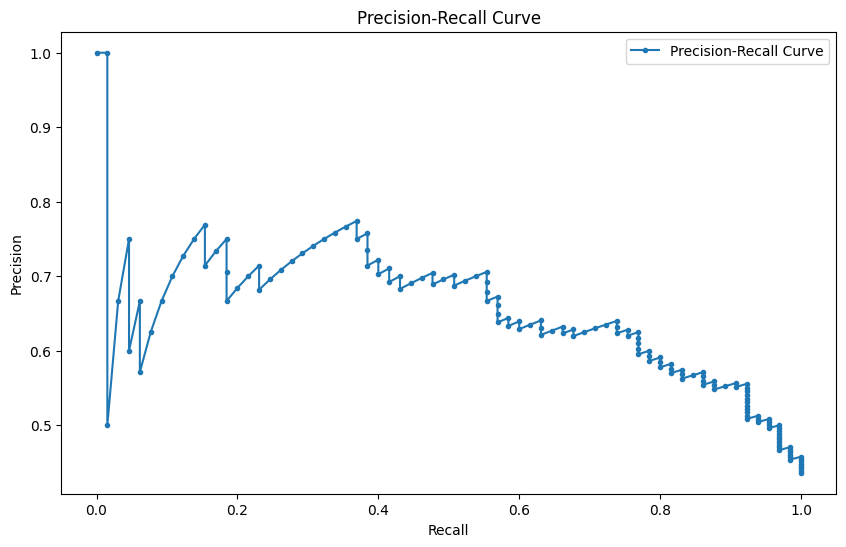

In [21]:
# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob_lr)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

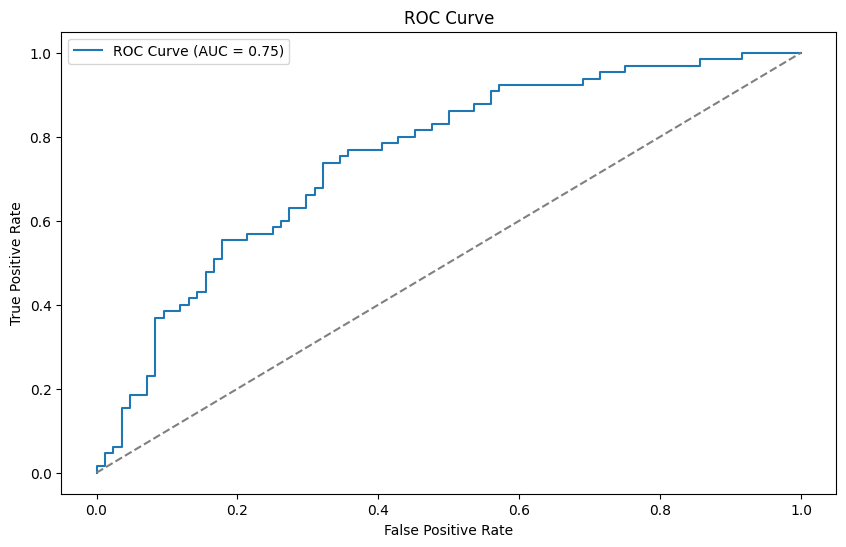

In [22]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [23]:
print("AUC:", roc_auc)

AUC: 0.7503663003663004


In [24]:
import random

def plot_predictions(images, true_labels, pred_labels, title, img_size=(64, 64), num_images=9):
    # Create a random sample of indices
    indices = random.sample(range(len(images)), num_images)

    # Plot the images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    for idx, ax in zip(indices, axes):
        img = images[idx].reshape(img_size[0], img_size[1], 3)
        true = true_labels[idx]
        pred = pred_labels[idx]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {true}, Pred: {pred}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

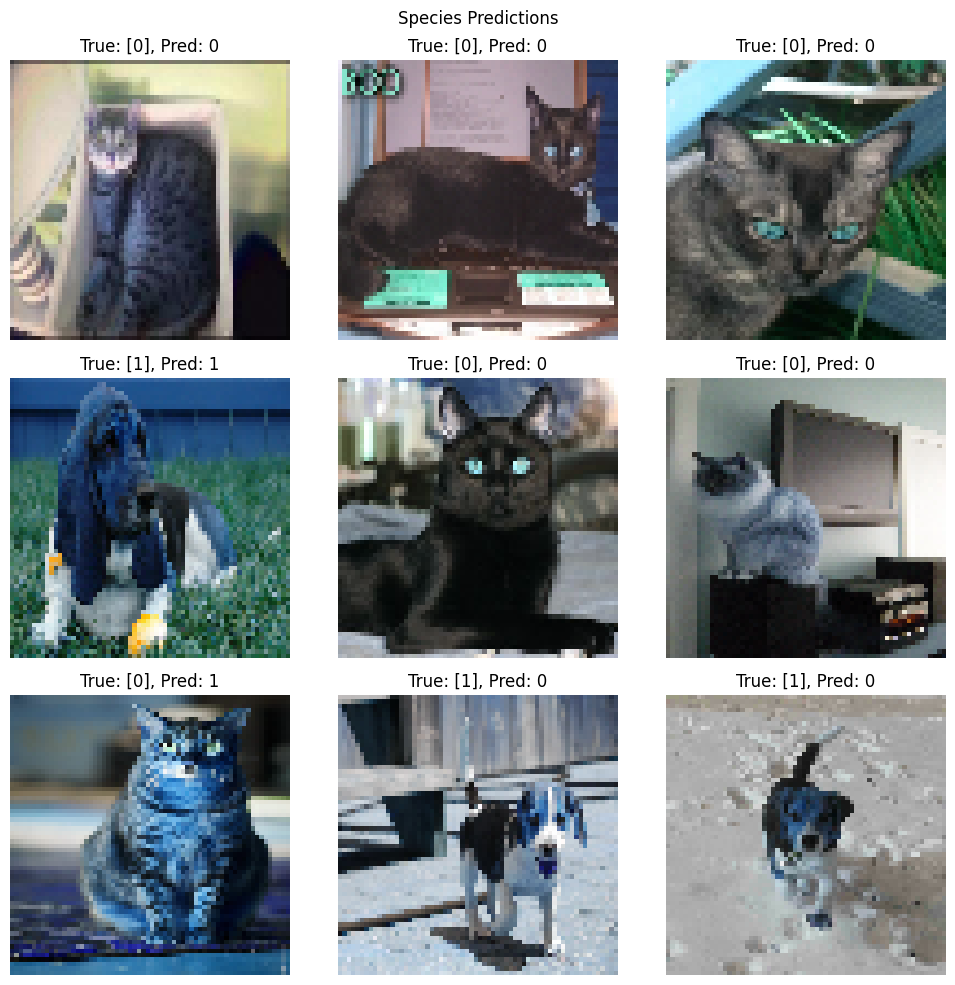

In [25]:
plot_predictions(X_test.reshape(-1, 64, 64, 3), y_test, y_pred, "Species Predictions")

## KNN Model

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 is for Manhattan, p=2 is for Euclidean distance
}


#KNN with 5-fold cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train.ravel())  #.ravel() to flatten y_train

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


In [28]:
# Train KNN model found by GridSearchCV
best_knn = grid_search.best_estimator_

# prediction with KNN model
y_pred_knn = best_knn.predict(X_test)

In [29]:
# Model performance
print("\nClassification Report for Best KNN:")
print(classification_report(y_test, y_pred_knn))
print("Accuracy for Best KNN:", accuracy_score(y_test, y_pred_knn))


Classification Report for Best KNN:
              precision    recall  f1-score   support

           0       0.65      0.82      0.73        84
           1       0.65      0.43      0.52        65

    accuracy                           0.65       149
   macro avg       0.65      0.63      0.62       149
weighted avg       0.65      0.65      0.64       149

Accuracy for Best KNN: 0.6510067114093959


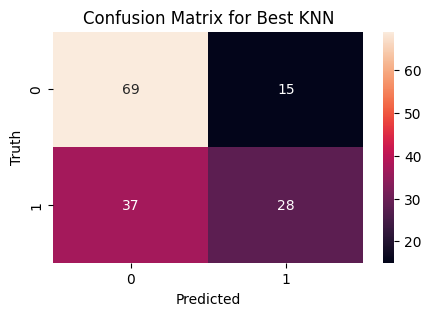

In [30]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(5, 3))
sn.heatmap(cm_knn, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Best KNN')
plt.show()

In [31]:
y_prob_lr = best_knn.predict_proba(X_test)[:, 1]  # Probabilities for ROC

In [32]:
# Loss Curve
train_sizes, train_scores, test_scores = learning_curve(best_knn, X_train, y_train, cv=5, scoring='neg_log_loss')
train_loss = -np.mean(train_scores, axis=1)
test_loss = -np.mean(test_scores, axis=1)

C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\rhmar\AppData\Roaming\Python\Python313\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was

In [33]:
for size, train_l, test_l in zip(train_sizes, train_loss, test_loss):
    print(f"Training Size: {size}, Training Loss: {train_l:.4f}, Test Loss: {test_l:.4f}")


Training Size: 27, Training Loss: 0.0000, Test Loss: 0.6754
Training Size: 90, Training Loss: 0.0000, Test Loss: 0.8690
Training Size: 152, Training Loss: 0.0000, Test Loss: 0.7474
Training Size: 214, Training Loss: 0.0000, Test Loss: 0.6426
Training Size: 277, Training Loss: 0.0000, Test Loss: 0.7268


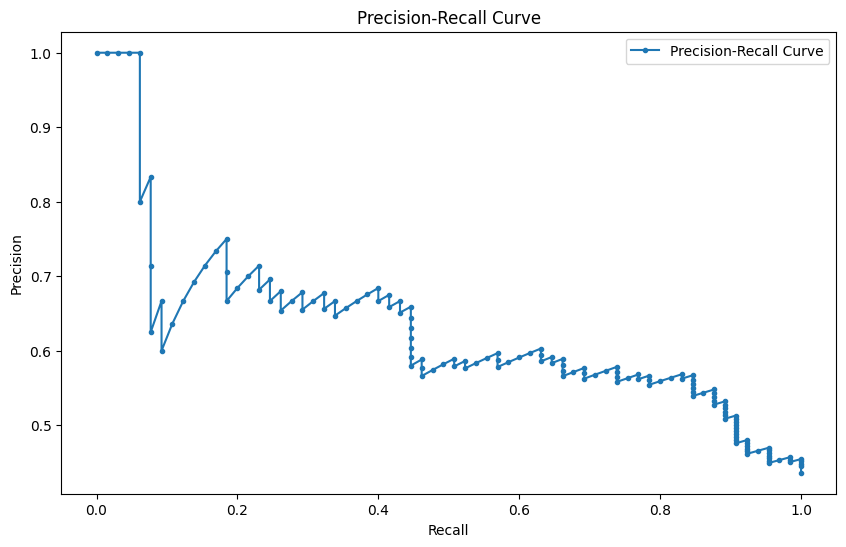

In [34]:
# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob_lr)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

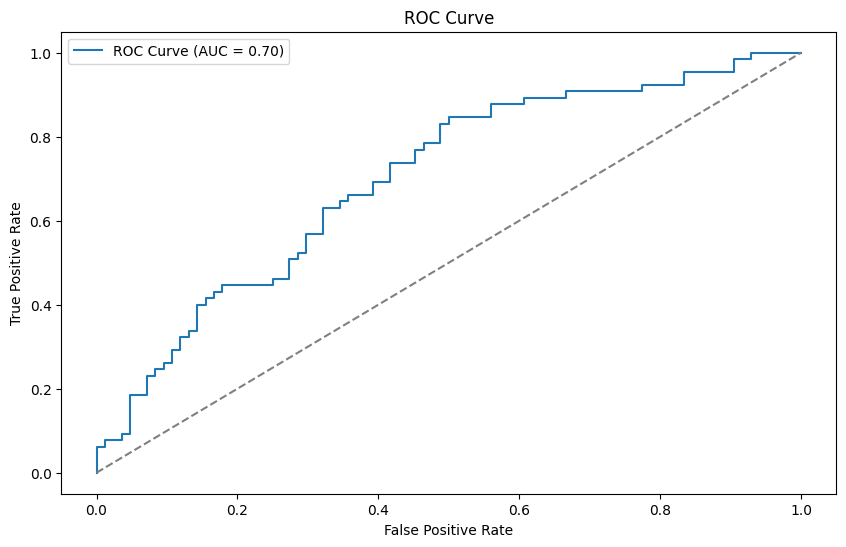

AUC: 0.6990842490842492


In [35]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("AUC:", roc_auc)